# Realistic Experiment: Confidence Interval Regression of Inaccessible Observables in Robotics

In this experiment, we evaluate our model's ability to predict confidence intervals for key observables in a realistic robotic scenario. Specifically, we use a simulated dataset of quadruped robot locomotion (`go1`) to estimate confidence intervals for two fundamental $\mathcal{G}$-invariant observables: **Kinetic Energy** and **Work Function**.

<div align="center">
    <img src="https://media4.giphy.com/media/v1.Y2lkPTc5MGI3NjExNWx4ampoZ2xobjRvanh4ODFhMXZ2d25jYXp0dm5hb3B3azVrd2dxMyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/hFoRNrXqJIi6BxJyVb/giphy.gif" alt="Quadruped walking on rough terrain" />
</div>

### Observables of Interest

1. The **work function** $U(q, \dot{q}, F)$. Represents the total instantaneous work done on or by the robot. This observable is typically inaccessible since it depends on external forces $F$ (e.g., contact, constraint, or disturbance forces) that are challenging to measure directly.

2. The **kinetic energy** $T(q, \dot{q}) = 0.5 \, \dot{q}^\top M(q) \, \dot{q}$
   Can be computed from sensor readings of the robot's joint positions and velocities. However, these measurements are noisy, leading to propagation errors in the kinetic energy estimation.

The relevance of these observables lies in their contribution to the robot's **Lagrangian function**, $\mathcal{L}(q, \dot{q}, F) = T(q, \dot{q}) - U(q, \dot{q}, F)$, a scalar function which fully characterizes the robot's dynamics. Hence, accurate estimation of these quantities, along with their associated uncertainties, is essential for improving various downstream robotics applications, including disturbance detection, state estimation, contact detection and localization, dynamics modeling, and optimal control.

____________

### Objective:
The goal of this experiment is to provide a data-driven model that can predict a confidence interval of $95\%$ of the kinetic energy and the work function as a function of available sensor measurements like joint positions $q$, joint velocities $\dot{q}$, IMU linear acceleration and angular velocity, feet velocities, etc.

We compare three different models:
- **Conformalized Quantile Regression (CQR)**: Which utilizes two MLPs to regress the upper and lower quantiles, and
- **NCP and eNCP models**: Trained as self-supervised representation learning algorithms, where the learned data representations and approximate conditional expectation operators are then used to predict the CondCDF of the target observables.

A summary of the results is provided below, showing that the CQR method fails to generalize its confidence intervals outside of the training distribution, and that eNCP features higher coverage than `NCP` and `CQR`, while mantaining a considerably similar set size as `NCP`.

<div align="center">
    <div style="display: inline-block; margin-right: 10px;">
        <img src="https://imgur.com/biBsNux" alt="Coverage quadruped experiment" width="400"/>
    </div>
    <div style="display: inline-block;">
        <img src="https://github.com/Danfoa/symm_rep_learn/blob/grf/paper/examples/conditional_quantile_regression/images/set_size_results.png" alt="Set size quadruped experiment" width="400"/>
    </div>
</div>
<div align="center">
    <div style="display: inline-block; margin-right: 10px;">
        <img src="./images/coverage_results.png" alt="Coverage quadruped experiment" width="400"/>
    </div>
    <div style="display: inline-block;">
        <img src="./images/set_size_results.png" alt="Set size quadruped experiment" width="400"/>
    </div>
</div>

In [1]:
from lightning import seed_everything

from symm_rep_learn.models.multivariateCQR import get_coverage, get_set_size

%load_ext autoreload
%autoreload 2
import os
import pathlib
import sys

import numpy as np
import pandas as pd

# Configure plotly for jupyter
import plotly.io as pio
import torch
from omegaconf import OmegaConf

# pio.renderers.default = "notebook_connected"
pio.renderers.default = "jupyterlab"
# pio.renderers.default = 'png'  # For github
pio.templates.default = "seaborn"

from symm_rep_learn.inference.encp import ENCPConditionalCDF
from symm_rep_learn.inference.ncp import NCPConditionalCDF

cwd = pathlib.Path(os.getcwd())
root_dir = cwd.parent.parent.parent
sys.path.append(str(cwd))
sys.path.append(root_dir)

from paper.experiments.GRF_uncertainty_regression import get_proprioceptive_data, get_uc_model, plot_gt_and_quantiles

# Paths to exemplars form the experiment which we will load.
ncp_path = (
    root_dir
    / "paper/results/GRF_regression/kinE_U_go1/robot=go1_lr=0.0001_bs=2048_pat=25_NCP_hu=512_hl=4_act=ELU_resY=False_lstsq=True/gamma=50 seed=1"
)
encp_path = (
    root_dir
    / "paper/results/GRF_regression/kinE_U_go1/robot=go1_lr=0.0001_bs=2048_pat=25_ENCP_hu=512_hl=4_act=ELU_resY=False_lstsq=True/gamma=50 seed=1"
)
cqr_path = (
    root_dir
    / "paper/results/GRF_regression/kinE_U_go1/robot=go1_lr=0.0001_bs=2048_pat=25_CQR_hu=512_hl=4_act=ELU_resY=False_lstsq=True/ seed=1"
)
paths = {"ncp": ncp_path, "encp": encp_path, "cqr": cqr_path}

ModuleNotFoundError: No module named 'symm_torch.utils.rep_theory'

In [2]:
import escnn
from escnn.nn import FieldType

# Load experiment runs configurations_____________________________________________
configs = {}
for model_name, model_path in paths.items():
    configs[model_name] = OmegaConf.load(model_path / ".hydra" / "config.yaml")
seeds = [cfg.seed for cfg in configs.values()]
assert np.unique(seeds).size == 1, (
    "All models must have the same seed so the dataset partitions "
    "are the same. as the ones the models were trained on"
)
# Load dataset______________________________________________________________________
cfg = configs["encp"]  # Any config will do.
seed_everything(cfg.seed)

cfg.dataset.path = root_dir / cfg.dataset.path
samples, datasets, (rep_x, rep_y), x_moments, y_moments, y_obs_dims = get_proprioceptive_data(cfg)
(x_train, y_train), (x_val, y_val), (x_test, y_test) = samples
train_ds, val_ds, test_ds = datasets

G = rep_x.group
# lat_rep = G.regular_representation
x_type = FieldType(gspace=escnn.gspaces.no_base_space(G), representations=[rep_x])
y_type = FieldType(gspace=escnn.gspaces.no_base_space(G), representations=[rep_y])

# Load models______________________________________________________________________
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")
models = {}
for model_name, model_cfg in configs.items():
    models[model_name] = get_uc_model(model_cfg, x_type, y_type)
    best_path = paths[model_name] / "last.ckpt"
    state_dict = torch.load(best_path, map_location=device, weights_only=True)["state_dict"]
    state_dict = {k.replace("model.", "", 1): v for k, v in state_dict.items()}
    models[model_name].load_state_dict(state_dict)
    models[model_name].to(device).eval()
    print(f"- Loaded trained {model_name}")
    print(f"\tNumber of parameters: {sum(p.numel() for p in models[model_name].parameters())}")

Seed set to 1
/home/danfoa/Projects/MorphoSymm/morpho_symm/utils/robot_utils.py:152: UserWarning:

Representation Q_js found while loading the robot go1. This happens when you load multiple robots in the same session. The old representation will be overwritten.

/home/danfoa/Projects/MorphoSymm/morpho_symm/utils/robot_utils.py:152: UserWarning:

Representation TqQ_js found while loading the robot go1. This happens when you load multiple robots in the same session. The old representation will be overwritten.



- qpos_js: C2|[Q_js]:12
- qvel_js: C2|[TqQ_js]:12
- base_lin_acc:base: C2|[R3]:3
- base_lin_vel:base: C2|[R3]:3
- base_lin_vel_err:base: C2|[R3]:3
- base_ang_vel:base: C2|[R3_pseudo]:3
- base_ang_vel_err:base: C2|[R3_pseudo]:3
- gravity_vector:base: C2|[R3]:3
- feet_vel:base: C2|[Rd_on_limbs]:12
- tau_ctrl_setpoint: C2|[TqQ_js]:12
- work: C2|[irrep_0]:1
- kinetic_energy: C2|[irrep_0]:1
- Loaded trained ncp
	Number of parameters: 1677312
- Loaded trained encp
	Number of parameters: 873472
- Loaded trained cqr
	Number of parameters: 1181952


# Configure the models for conditional quantile regression

In [3]:
alpha = cfg.alpha  # All models configured with the same alpha
encp_ccdf = ENCPConditionalCDF(
    model=models["encp"], y_train=y_type(y_train), support_discretization_points=500, lstsq=True
)
ncp_ccdf = NCPConditionalCDF(model=models["ncp"], y_train=y_train, support_discretization_points=500, lstsq=True)
# Query the quantiles for all the testing set
q_low_encp, q_high_encp = encp_ccdf.conditional_quantiles(x_cond=x_type(x_test), alpha=alpha)
q_low_ncp, q_high_ncp = ncp_ccdf.conditional_quantiles(x_cond=x_test, alpha=alpha)
q_low_cqr, q_high_cqr = models["cqr"](x_test)  # CQR model is already a quantile regression model.

quantiles = {}
coverage, set_size = {}, {}
for model_name in ["encp", "ncp", "cqr"]:
    q_low, q_high = locals()[f"q_low_{model_name}"], locals()[f"q_high_{model_name}"]
    q_low = torch.tensor(q_low, device=device, dtype=y_train.dtype)
    q_high = torch.tensor(q_high, device=device, dtype=y_train.dtype)
    quantiles[model_name] = (q_low, q_high)
    coverage[model_name] = get_coverage(q_low, q_high, y_test)
    set_size[model_name] = get_set_size(q_low, q_high)
# Print a table with the coverage and set size of the models
pd.DataFrame({"coverage": coverage, "set_size": set_size})

/tmp/ipykernel_50544/3256168475.py:17: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_50544/3256168475.py:18: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



,coverage,set_size
encp,tensor(0.9406),tensor(2.0992)
ncp,tensor(0.5158),tensor(3.5858)
cqr,tensor(0.0450),tensor(0.5756)


# Confidence intervals of CQR

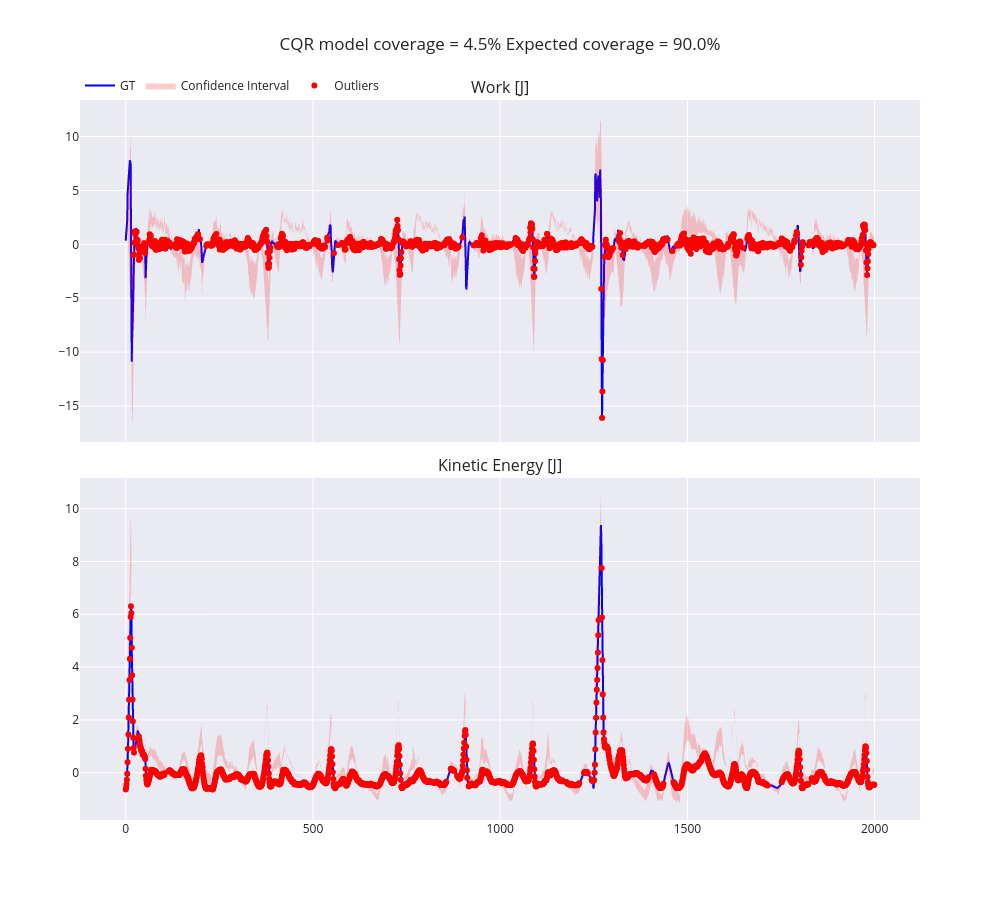

In [17]:
subtitles = ["Work [J]", "Kinetic Energy [J]"]
window = slice(0, 2000)
width, height = 1000, 900
title = f'CQR model coverage = {coverage["cqr"]*100:.1f}% Expected coverage = {(1-alpha)*100:.1f}%'
q_low, q_high = quantiles["cqr"]
fig = plot_gt_and_quantiles(y_test[window], q_low[window], q_high[window], subtitles=subtitles, ncols=1)
fig.update_layout(title=title, title_x=0.5, showlegend=True, width=width, height=height)  # Change fig size
fig.update_layout(legend=dict(x=0, y=1, traceorder="normal", orientation="h", yanchor="bottom", xanchor="left"))

# **Confidence intervals of NCP**

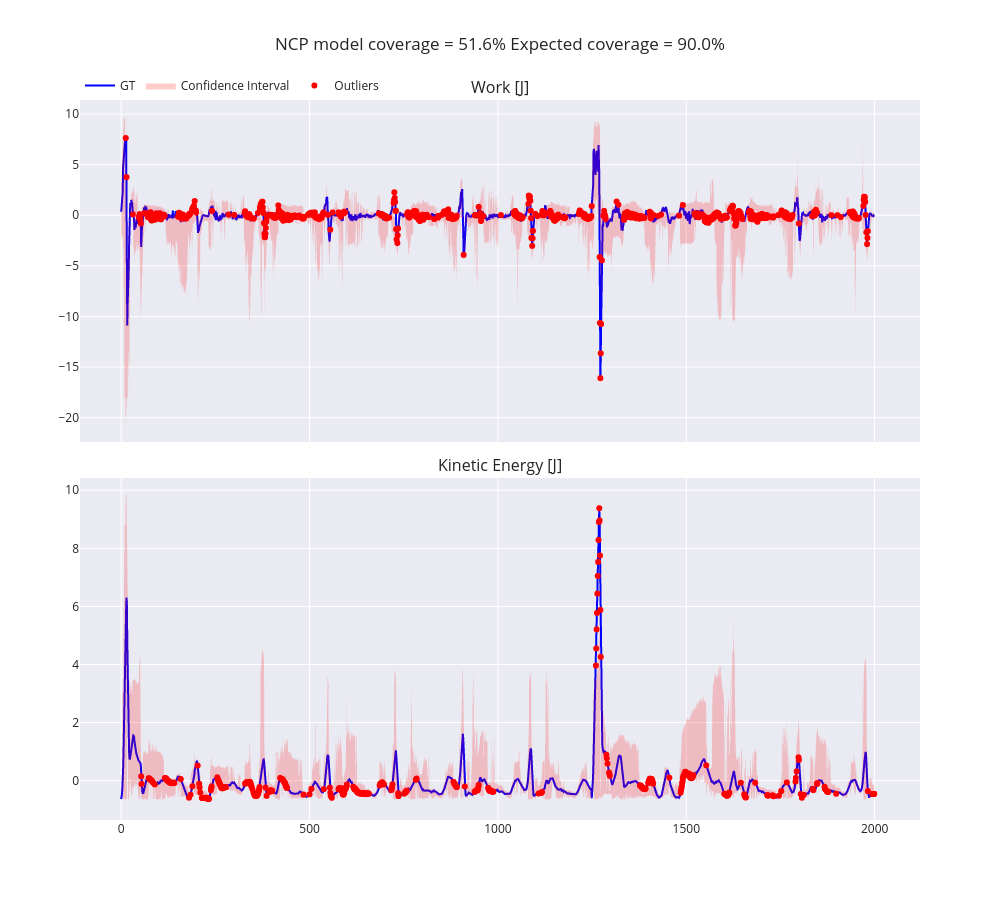

In [18]:
title = f'NCP model coverage = {coverage["ncp"]*100:.1f}% Expected coverage = {(1-alpha)*100:.1f}%'
q_low, q_high = quantiles["ncp"]
fig = plot_gt_and_quantiles(y_test[window], q_low[window], q_high[window], subtitles=subtitles, ncols=1)
fig.update_layout(title=title, title_x=0.5, showlegend=True, width=width, height=height)
fig.update_layout(legend=dict(x=0, y=1, traceorder="normal", orientation="h", yanchor="bottom", xanchor="left"))

# **Confidence intervals of ENCP** (Our model)

Crucially, note how the uncertainty is higher in the period of time of a disturbance (high energy impact peaks), and the consequent recovery time (transient dynamics).

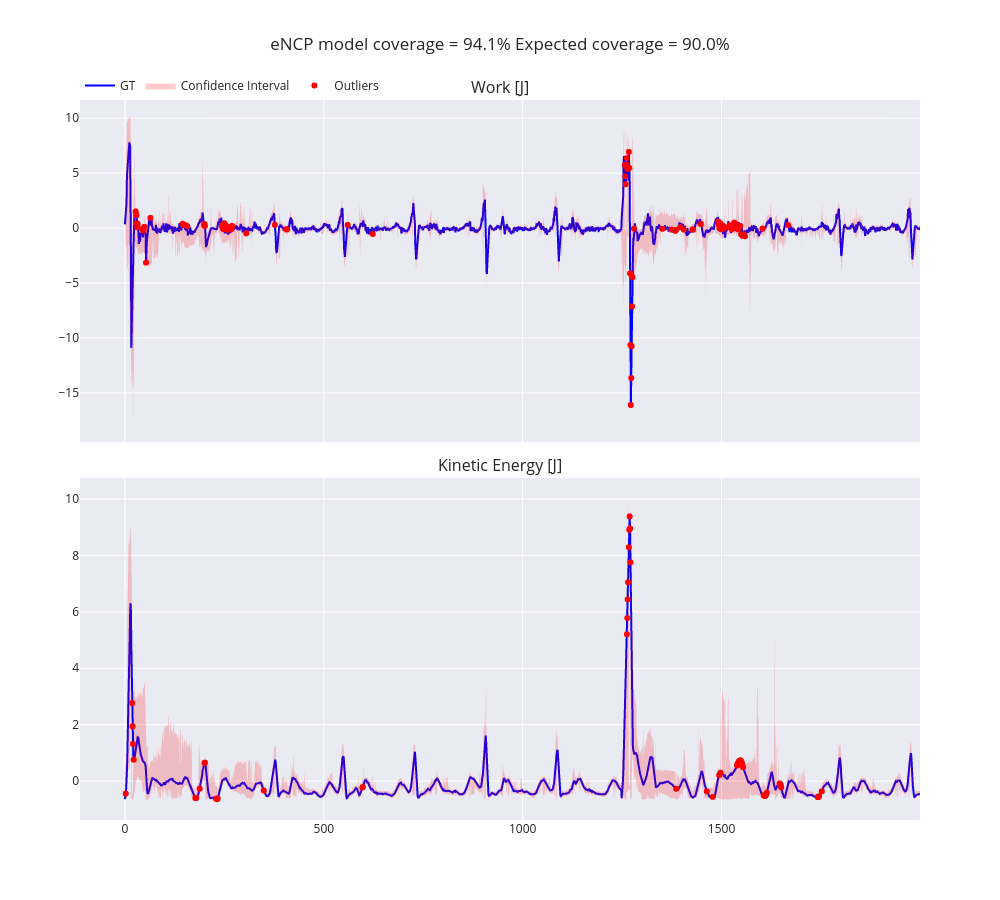

In [19]:
title = f'eNCP model coverage = {coverage["encp"]*100:.1f}% Expected coverage = {(1-alpha)*100:.1f}%'
q_low, q_high = quantiles["encp"]
fig = plot_gt_and_quantiles(y_test[window], q_low[window], q_high[window], subtitles=subtitles, ncols=1)
fig.update_layout(title=title, title_x=0.5, showlegend=True, width=width, height=height)
fig.update_layout(legend=dict(x=0, y=1, traceorder="normal", orientation="h", yanchor="bottom", xanchor="left"))